In [205]:
%matplotlib inline

In [206]:
from scipy.io import loadmat
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [207]:
rois = ['V1', 'V2', 'V3', 'hV4', 'IOG', 'pFus', 'mFus']

In [208]:
def filter_voxels(res, cutoff=50):
    # as in Kay et al., select non-noisy voxels with at least 50% variance explained
    idx = res['aggregatedtestperformance'][0] >= cutoff
    return np.median(res['params'][..., idx], axis=0)

In [209]:
params = dict()
for hemi in ['L', 'R']:
    for roi in rois:
        ok_voxs = []
        for s in range(1, 4):
            res = loadmat(f'../output/sub-{s:02d}_{hemi}{roi}.mat')
            ok_voxs.append(filter_voxels(res))
        ok_voxs = np.hstack(ok_voxs)
        params[f'{hemi}{roi}'] = ok_voxs

/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


In [228]:
for roi, val in params.items():
    print(f'{roi}: {val.shape[1]}')

LV1: 732
LV2: 752
LV3: 990
LhV4: 423
LIOG: 542
LpFus: 388
LmFus: 175
RV1: 807
RV2: 601
RV3: 846
RhV4: 402
RIOG: 357
RpFus: 317
RmFus: 256


In [210]:
params.keys()

dict_keys(['LV1', 'LV2', 'LV3', 'LhV4', 'LIOG', 'LpFus', 'LmFus', 'RV1', 'RV2', 'RV3', 'RhV4', 'RIOG', 'RpFus', 'RmFus'])

In [211]:
# the parameters of the CSS model are [R C S G N] where
#   R is the row index of the center of the 2D Gaussian
#   C is the column index of the center of the 2D Gaussian
#   S is the standard deviation of the 2D Gaussian
#   G is a gain parameter
#   N is the exponent of the power-law nonlinearity

In [212]:
def eccentricity(x, y, res=100, width_degree=12.5):
    m = res/2
    scaling = width_degree/res
    x = (x-m) * scaling
    y = (y-m) * scaling
    return np.sqrt(x**2 + y**2)

def prf_size(sd, n, res=100, width_degree=12.5):
    scaling = width_degree/res
    return scaling * sd/np.sqrt(n)

In [213]:
ecc_size = dict()
for roi, pp in params.items():
    ecc_size[roi] = np.vstack((eccentricity(*pp[:2]), prf_size(pp[2], pp[-1])))

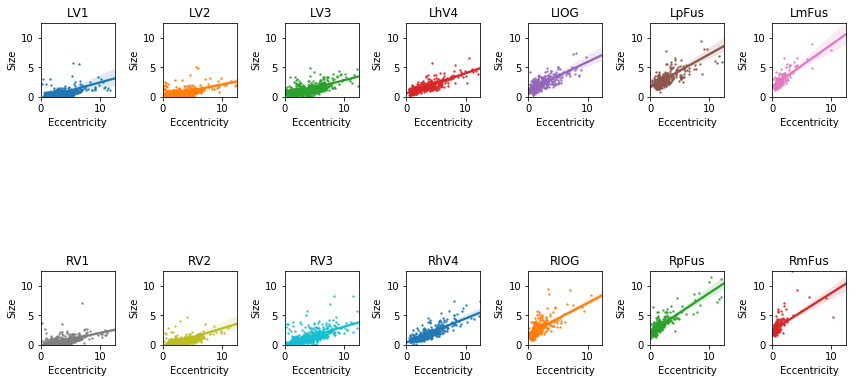

In [214]:
fig, axs = plt.subplots(2, 7, figsize=(12, 8))
for i, hemi in enumerate(['L', 'R']):
    axs_ = axs[i]
    for ax, roi in zip(axs_, rois):
        roi_name = f'{hemi}{roi}'
        pp = ecc_size[roi_name]
        sns.regplot(x=pp[0], y=pp[1], scatter_kws={'s': 2}, ax=ax, )
        ax.set_xlim([0, 12.5]);
        ax.set_ylim([0, 12.5]);
        ax.set_aspect('equal');
        ax.set_title(roi_name)
        ax.set_xlabel('Eccentricity')
        ax.set_ylabel('Size')
plt.tight_layout()

In [222]:
# combine hemispheres
ecc_size_combined = dict()
for roi in rois:
    ecc_size_combined[roi] = np.hstack((ecc_size[f'L{roi}'], ecc_size[f'R{roi}']))

In [224]:
ecc_size_combined['V1'].shape

(2, 1539)

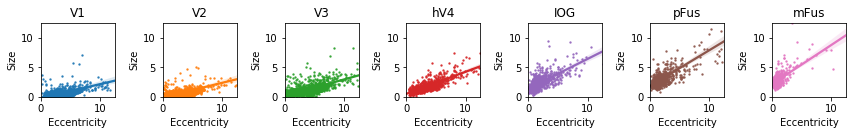

In [231]:
fig, axs = plt.subplots(1, 7, figsize=(12, 8))
for ax, roi in zip(axs, rois):
    roi_name = roi
    pp = ecc_size_combined[roi_name]
    sns.regplot(x=pp[0], y=pp[1], scatter_kws={'s': 2}, ax=ax, )
    ax.set_xlim([0, 12.5]);
    ax.set_ylim([0, 12.5]);
    ax.set_aspect('equal');
    ax.set_title(roi_name)
    ax.set_xlabel('Eccentricity')
    ax.set_ylabel('Size')
plt.tight_layout()

In [215]:
from scipy.stats import linregress

In [232]:
slope_int = dict()
for roi, (ecc, size) in ecc_size_combined.items():
    reg = linregress(ecc, size)
    slope_int[roi] = reg[:2]

In [233]:
slope_int

{'V1': (0.23417614555337313, -0.20373062588655744),
 'V2': (0.24462499204130872, -0.09382537467443541),
 'V3': (0.2777193287780663, 0.1432069832445344),
 'hV4': (0.37201622531846557, 0.5115256487101663),
 'IOG': (0.501028848917349, 1.3881746272025561),
 'pFus': (0.603558230325913, 1.8489509656288012),
 'mFus': (0.6598366325996826, 2.1578970683041945)}

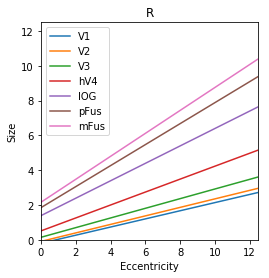

In [236]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for roi in rois:
    slope, intercept = slope_int[roi]
    ax.plot([0, 12.5], [intercept, 12.5*slope + intercept], label=roi)
ax.set_title(hemi)
ax.set_xlim([0, 12.5]);
ax.set_ylim([0, 12.5]);
ax.set_aspect('equal');
ax.set_xlabel('Eccentricity')
ax.set_ylabel('Size')
ax.legend()

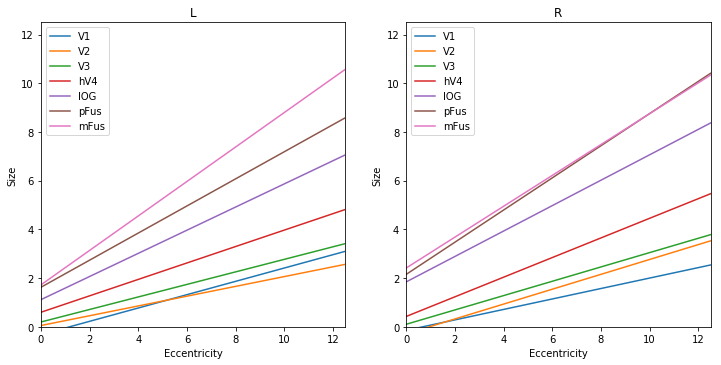

In [218]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
for ax, hemi in zip(axs, ['L', 'R']):
    for roi in rois:
        slope, intercept = slope_int[f'{hemi}{roi}']
        ax.plot([0, 12.5], [intercept, 12.5*slope + intercept], label=roi)
    ax.set_title(hemi)
    ax.set_xlim([0, 12.5]);
    ax.set_ylim([0, 12.5]);
    ax.set_aspect('equal');
    ax.set_xlabel('Eccentricity')
    ax.set_ylabel('Size')
    ax.legend()

In [237]:
median_ecc = dict()

for roi, (ecc, size) in ecc_size.items():
    median_ecc[roi] = np.median(ecc)

In [239]:
import pandas as pd

In [249]:
df_ecc = pd.DataFrame(list(median_ecc.items()), columns=['roi', 'eccentricity'])
df_ecc['hemi'] = [r[0] for r in df_ecc.roi]
df_ecc['roi'] = [r[1:] for r in df_ecc.roi]

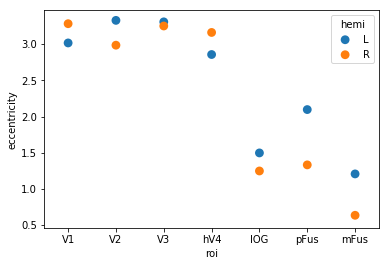

In [252]:
sns.pointplot(x='roi', y='eccentricity', hue='hemi', data=df_ecc, join=False)

In [257]:
# save parameters for later use
header = ['row', 'col', 'std', 'gain', 'n']

for roi, param in params.items():
    np.savetxt(f'../output/{roi}_median_param.txt', param, header=' '.join(header))